# Dev notebook for automating mapping

Need to do a few things:
1. Read in data
2. Montage data
3. Read in coordinates (I think I only really need them for the first tile)
4. Make coordinates for the rest (should be easy)
5. Read in coordinates for SIM data
6. Pare down SIM data (take first of each similar name)
7. Plot

In [1]:
import os
import glob
import re
import skimage.external.tifffile as tif
import numpy as np
import pandas as pd
import textwrap

from dphutils import bin_ndarray

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LogNorm
import matplotlib.transforms

%load_ext autoreload
%autoreload 2

from mapmaker import *

# Making the montage

In [2]:
def load_stack(top_dir):
    paths = []
    for i in range(100):
        subpaths = sorted(glob.glob(top_dir + "/*ch{}*.tif".format(i)))
#         for path in subpaths:
#             print(path)
        if not len(subpaths):
            break
        paths.append(subpaths)
    # paths are being read in reverse, need to swap stack
    return np.asarray([[tif.imread(p) for p in subpaths] for subpaths in paths])

In [2]:
data = load_stack("fixtures/C2_Montage/")

/Users/david/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [4]:
def read_montage_settings(path):
    overall_settings = pd.read_csv(path, nrows=1)
    tile_settings = pd.read_csv(path, skiprows=2, header=0).iloc[1:-2].dropna(1, 'all')
    shape = tuple(overall_settings[['# Subvolume Y', '# Subvolume X']].values.squeeze())
    # center in um
    tile0_loc = tile_settings.iloc[0][["Absolute Y (um)", "Absolute X (um)"]].values
    return shape, tile0_loc.astype(float)

In [3]:
shape, tile0_loc = read_montage_settings("fixtures/C2_Montage/3D settings_C2_Montage_0000.csv")
shape, tile0_loc

((19, 19), array([ 11498.48,   6578.91]))

In [91]:
def montage(stack, shape):
    new_shape = stack.shape[:1] + shape + stack.shape[2:]
    c, dy, dx, ny, nx = new_shape
    return np.rollaxis(stack.reshape(new_shape), 2, 4).reshape(c, dy * ny, dx * nx)

In [7]:
def calc_extent(tile0_loc, tile_shape, montage_shape, pixel_size=0.13):
    """Remember that the image is oriented such that the x-axis
    is decreasing from left to right
    
    All units in um
    
    extent : scalars (left, right, bottom, top), optional, default: None
    The location, in data-coordinates, of the lower-left and
    upper-right corners. If `None`, the image is positioned such that
    the pixel centers fall on zero-based (row, column) indices.
    """
    y0, x0 = tile0_loc
    ny, nx = tile_shape
    ny_tot, nx_tot = np.multiply(tile_shape, montage_shape)
    top = y0 + (ny // 2) * pixel_size
    left = x0 + (nx // 2) * pixel_size
    bottom = top - ny_tot * pixel_size
    right = left - nx_tot * pixel_size
    return left, right, bottom, top

# Extract data from SIM settings files

In [8]:
# regex to find the x y positions of each SIM stack
re_x = re.compile("(?<=X \(mm\) = )(-?\d+\.\d+)")
re_y = re.compile("(?<=Y \(mm\) = )(-?\d+\.\d+)")

In [9]:
def clean_path(path):
    """Clean the names of the SIM images"""
    split_path = os.path.abspath(path).split(os.path.sep)
    name = split_path[-2]
    return "_".join(name.split("_")[:-2])

In [10]:
def extract_locations(top_level_path):
    d = dict()
    for path in glob.iglob(top_level_path + "/*/*config.txt"):
        with open(path, "r") as f:
            tmp = f.readlines()
            try:
                d[path] = (set(re_y.findall("\n".join(tmp))).pop(), set(re_x.findall("\n".join(tmp))).pop())
            except KeyError:
                print("No information in", path)
                continue
    return {clean_path(k): np.asarray(v).astype(float) for k, v in d.items()}

In [11]:
def extract_locations_csv(csv_path):
    """Extract locations from a csv file generated by motion GUI"""
    d = pd.read_csv(csv_path)
    d = d[~d["Name"].str.contains("Pos")]
    return {dd["Name"]: dd[["Y (mm)", "X (mm)"]].values.astype(float) for i, dd in d.iterrows()}

In [13]:
def make_rec(y, x, width, height):
    return plt.Rectangle((x - width / 2, y - height / 2), width, height, color='w', linewidth=1,
                   fill=False)

In [4]:
dd = extract_locations_csv("fixtures/Imaged Cells 1.csv")
dd

{'Cell 1': array([ 10.55285,   5.90347]),
 'Cell 2': array([ 10.73302,   5.19243]),
 'Cell 3': array([ 10.77506,   5.09484]),
 'Cell 4': array([ 10.66875,   4.90822]),
 'Cell 5': array([ 10.01961,   5.09429])}

In [19]:
shape

(19, 19)

In [5]:
montage_data = montage(bin_ndarray(data, (3, 361, 80, 80)), shape)
extent = calc_extent(tile0_loc, (80, 80), shape, pixel_size=1.3)

In [6]:
from dphplotting import auto_adjust

In [7]:
def make_fig(montage_data, extent, locations, savename, scalefactor, auto=True, **kwargs):
    dpi = 300
    shape = np.array(montage_data.shape)
    inches = shape / dpi * scalefactor
    fig, ax = plt.subplots(figsize=inches)
    default_vs = {k:v for k, v in {k: kwargs.pop(k, None) for k in ("vmin", "vmax")}.items() if v is not None}
    normed_data = PowerNorm(0.5)(montage_data, **default_vs)
    if auto:
        auto_vs = auto_adjust(normed_data)
    else:
        auto_vs = dict()
    kwargs.update(auto_vs)
    kwargs
    ax.matshow(normed_data, extent=extent, **kwargs)
    for title, point in locations.items():
        diameter = 512 * 0.13
        # right now y, x points are recorded in mm not um so we have to convert them.
        y, x = point * 1000
        ax.add_patch(make_rec(y, x, diameter, diameter))

        ax.annotate(textwrap.fill(title, 20), xy=(x, y), xycoords="data",
                    bbox=dict(pad=0.3, color=(1, 1, 1, 0.5), lw=0),
                    xytext=(x, y + diameter / 2 * 1.3),
                    textcoords='data', color='k',
                   horizontalalignment='center', verticalalignment='bottom',
                   multialignment="center")
    # fix borders and such
#     ax.axis("off")
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.xaxis.set_major_locator(plt.NullLocator())
#     ax.yaxis.set_major_locator(plt.NullLocator())
#     ax.margins(tight=True)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    # save the fig
    bbox = matplotlib.transforms.Bbox(((0, 0), inches))
    fig.savefig(savename, dpi=300, bbox_inches=bbox)

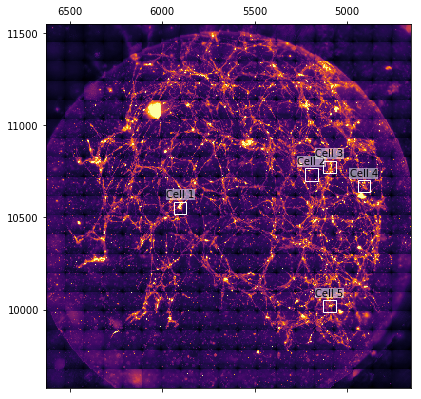

In [8]:
make_fig(montage_data[0], extent, dd, "junk.png", 1, cmap="inferno")